In [60]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from tqdm import tqdm

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Generate synthetic data
n_samples = 1000
X, _ = make_swiss_roll(n_samples=n_samples, noise=0.1)
X = X[:, [0, 2]]  # Keep only 2D coordinates
X = (X - X.mean(axis=0)) / X.std(axis=0)  # Normalize

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X)
dataset = TensorDataset(X_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


In [61]:
# Define the VAE architecture
class VAE(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=256, latent_dim=2):
        super(VAE, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Latent space parameters
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
        
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_var(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

    def sample(self, n_examples):
        z_dim = self.latent_dim
        device = next(self.parameters()).device
        z = torch.randn(n_examples, z_dim, device=device)
        return self.decode(z)


In [62]:
# Initialize model and optimizer
latent_dim = 2
model = VAE(hidden_dim=256, latent_dim=2)
# model = VAE(hidden_dim=128, latent_dim=latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(f"model params: {sum(p.numel() for p in model.parameters())}")

# Loss function
def loss_function(recon_x, x, mu, log_var):
    # Reconstruction loss
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    
    # KL divergence loss
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    return MSE + KLD * 0.1


model params: 134662


In [63]:
# Training loop
n_epochs = 100
losses = []

for epoch in tqdm(range(n_epochs)):
    epoch_loss = 0
    for batch_idx, (data,) in enumerate(dataloader):
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = model(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    losses.append(epoch_loss / len(dataloader.dataset))



100%|██████████| 100/100 [00:03<00:00, 26.95it/s]


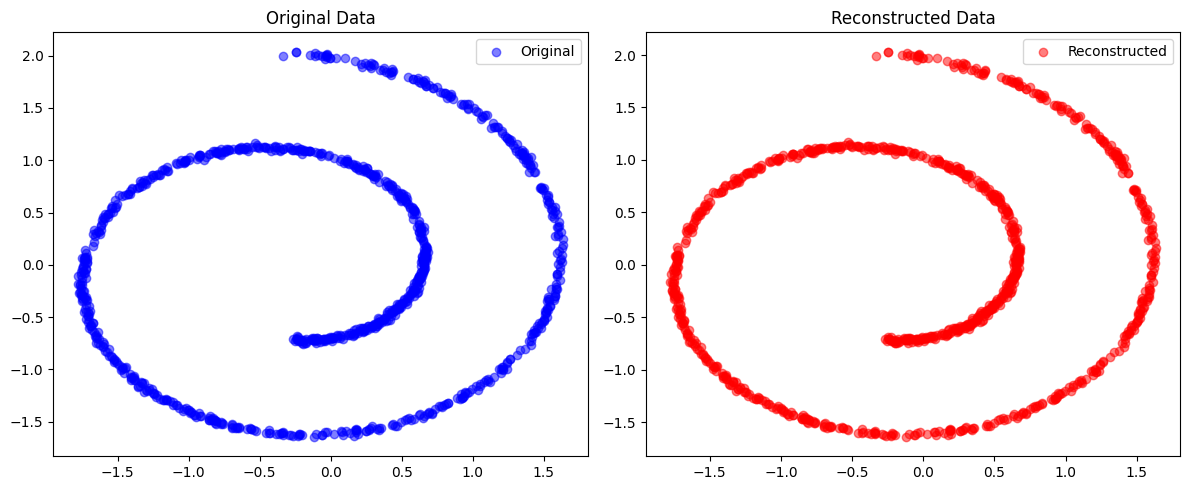

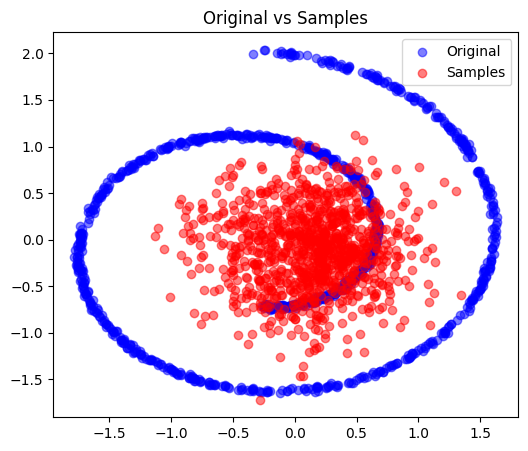

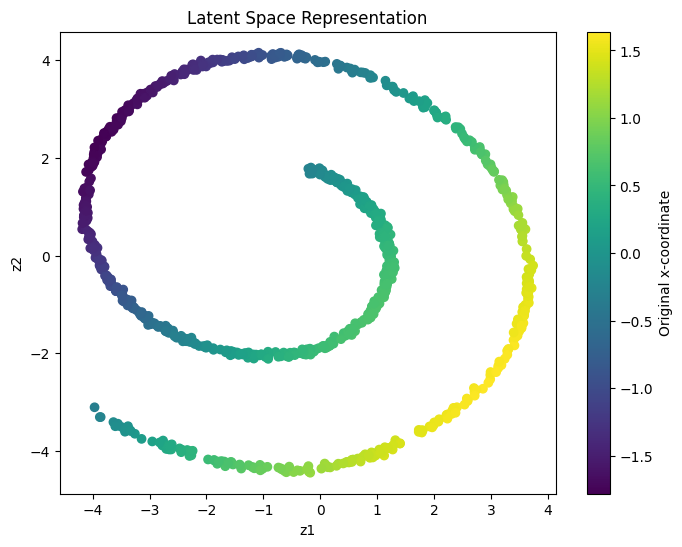

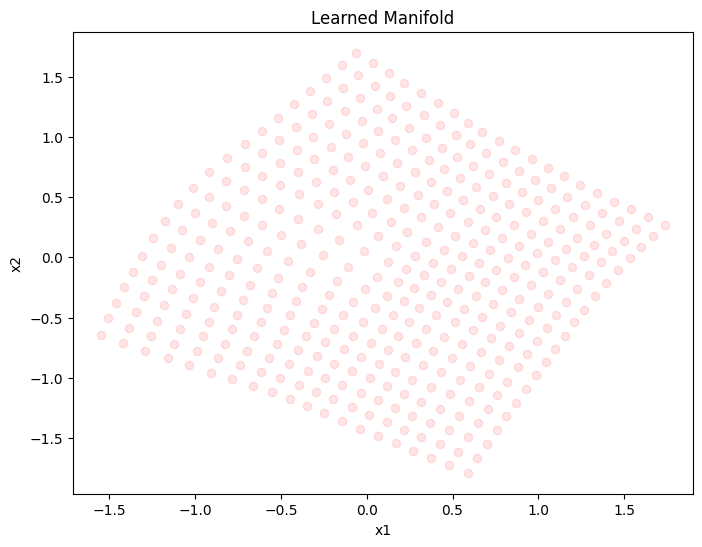

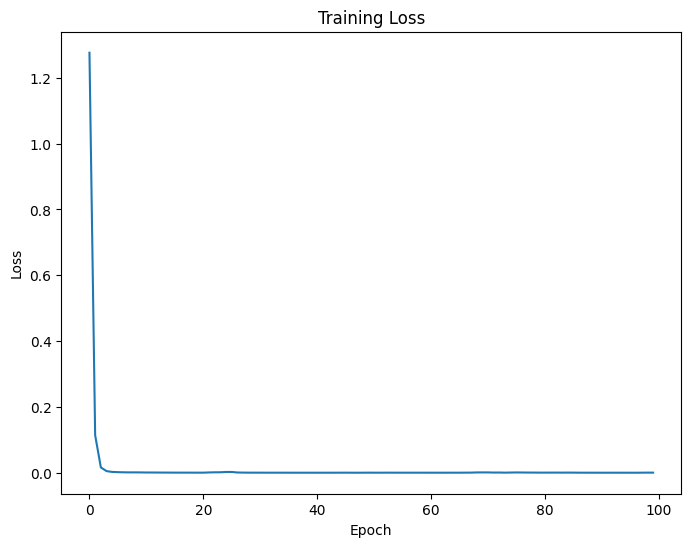

chamfer distance:  0.017696336
chamfer distance:  0.6447897


In [64]:

model.eval()
with torch.no_grad():
    # Get reconstructions
    recon_data, _, _ = model(X_tensor)
    recon_data = recon_data.numpy()

# get samples
with torch.no_grad():
    samples = model.sample(1000)
    samples = samples.numpy()

# Visualization functions
def plot_original_vs_reconstructed():
    model.eval()
    with torch.no_grad():
        
        # Plot
        plt.figure(figsize=(12, 5))
        
        plt.subplot(121)
        plt.scatter(X[:, 0], X[:, 1], c='blue', alpha=0.5, label='Original')
        plt.title('Original Data')
        plt.legend()
        
        plt.subplot(122)
        plt.scatter(recon_data[:, 0], recon_data[:, 1], c='red', alpha=0.5, label='Reconstructed')
        plt.title('Reconstructed Data')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

def plot_latent_space():
    model.eval()
    with torch.no_grad():
        # Get latent space representations
        mu, log_var = model.encode(X_tensor)
        z = model.reparameterize(mu, log_var)
        z = z.numpy()
        
        plt.figure(figsize=(8, 6))
        plt.scatter(z[:, 0], z[:, 1], c=X[:, 0], cmap='viridis')
        plt.colorbar(label='Original x-coordinate')
        plt.title('Latent Space Representation')
        plt.xlabel('z1')
        plt.ylabel('z2')
        plt.show()

def plot_manifold():
    model.eval()
    with torch.no_grad():
        # Create a grid in latent space
        grid_size = 20
        z1 = np.linspace(-3, 3, grid_size)
        z2 = np.linspace(-3, 3, grid_size)
        z1, z2 = np.meshgrid(z1, z2)
        
        z_grid = np.column_stack((z1.ravel(), z2.ravel()))
        z_tensor = torch.FloatTensor(z_grid)
        
        # Decode the grid points
        x_decoded = model.decode(z_tensor)
        x_decoded = x_decoded.numpy()
        
        plt.figure(figsize=(8, 6))
        plt.scatter(x_decoded[:, 0], x_decoded[:, 1], c='red', alpha=0.1)
        plt.title('Learned Manifold')
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.show()


def plot_original_vs_samples():
    plt.figure(figsize=(6, 5))
    plt.scatter(X[:, 0], X[:, 1], c='blue', alpha=0.5, label='Original')
    plt.scatter(samples[:, 0], samples[:, 1], c='red', alpha=0.5, label='Samples')
    plt.title('Original vs Samples')
    plt.legend()
    plt.show()

# Plot results
plot_original_vs_reconstructed()
plot_original_vs_samples()
if latent_dim == 2:
    plot_latent_space()
    plot_manifold()

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# chamfer distance
def chamfer_distance(x, y):
    # make sure they are numpy arrays
    if isinstance(x, torch.Tensor):
        x = x.numpy()
    if isinstance(y, torch.Tensor):
        y = y.numpy()
    
    x = x.reshape(-1, 2)
    y = y.reshape(-1, 2)

    dist = np.sqrt(((x[:, None] - y[None])**2).sum(-1))
    return dist.min(axis=0).mean() + dist.min(axis=1).mean()


print("chamfer distance: ", chamfer_distance(X_tensor, recon_data))
print("chamfer distance: ", chamfer_distance(X_tensor, samples))